In [1]:
import simpy
import uuid
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


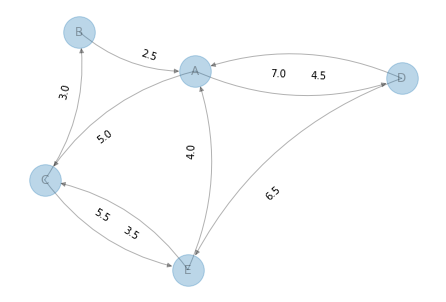

In [2]:
df = pd.DataFrame({'s': ['D', 'A', 'B', 'C', 'A', 'D', 'C', 'E', 'E'],
                   't': ['A', 'D', 'A', 'E', 'C', 'E', 'B', 'A', 'C'],
                   'w': [7., 4.5, 2.5, 3.5, 5., 6.5, 3., 4., 5.5]})
G = nx.from_pandas_edgelist(df, 's', 't', edge_attr=True, create_using=nx.DiGraph())
pos = nx.kamada_kawai_layout(G, weight='w')
labels = nx.get_edge_attributes(G, 'w')
nx.draw(G, pos, with_labels=True, node_size=1000, alpha=0.3, arrows=True, connectionstyle='arc3,rad=0.2')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, label_pos=0.4)
plt.show()

In [3]:
class AppSite(object):
    """
    Application site, i.e. tool, in the FAB.
    This corresponds to a node in the graph.
    We model an application site using the simpy.Resource data type.
    We impose FOUP capacity constraints on the buffer and the application.
    Constraint: app_capacity <= buffer_capacity
    """
    def __init__(self, env, node, app_capacity, buffer_capacity, processing_time, buffering_time):
        self.node = node
        self.app = simpy.Resource(env, capacity=app_capacity)
        self.buffer = simpy.Resource(env, capacity=buffer_capacity)
        self.processing_time = processing_time
        self.buffering_time = buffering_time

In [4]:
class RailPath(object):
    """
    Path in the FAB's overhead rail system.
    This corresponds to an edge in the graph.
    We model a rail path using the simpy.Store data type.
    We use shared resource objects to model rail path traffic flow.
    """
    def __init__(self, env, edge, weight, traffic_function):
        self.edge = edge
        self.ohts = simpy.Store(env)
        self.weight = weight
        self.traffic_function = traffic_function
    
    def transfer_time(self):
        return self.weight + self.traffic_function(len(self.ohts.items))

In [5]:
class FOUP(object):
    """
    Front-opening unified pod containing semiconductor wafers.
    The goal of the FAB is to process wafers as efficiently as possible.
    Our FOUP representation uses an ordered list of application demands.
    """
    def __init__(self, env, create_time, demands, uuid):
        self.env = env
        self.create_time = create_time
        self.demands = demands
        self.location = demands[0]
        self.uuid = uuid
        # WAIT IN, TRANSFERRING, COMPLETED, APPLICATION, WAIT OUT
        self.status = 'WAIT IN'

    def at_destination(self):
        return len(self.demands) > 0 and self.demands[0] == self.location

    def can_use(self, app_site):
        return ((self.status == 'WAIT IN' or self.status == 'COMPLETED') and
                self.at_destination() and self.location == app_site.node)

    def use(self, app_site):
        if self.can_use(app_site):
            if self.status == 'WAIT IN':
                # create FOUP
                yield self.env.timeout(self.create_time)
                self.buf_request = app_site.buffer.request()
                yield self.buf_request
            self.status = 'APPLICATION'
            with app_site.app.request() as req:
                yield req
                print('FOUP %s using AppSite %s at time %3.1f' %
                      (self.uuid, app_site.node, self.env.now))
                yield self.env.timeout(app_site.processing_time)
                # complete the leading demand
                self.demands = self.demands[1:]
                self.status = 'COMPLETED' if len(self.demands) > 0 else 'WAIT OUT'
            # this technically belongs in acquire, but the "training wheels"
            # of using it here make deadlock impossible
            app_site.buffer.release(self.buf_request)

In [6]:
class OHT(object):
    """
    Overhead hoist transfer in the FAB.
    OHTs carry FOUPs from one application site to another via rail paths in the FAB.
    """
    def __init__(self, env, location, uuid):
        self.env = env
        self.location = location
        self.uuid = uuid
        # PARKED, ENROUTE, ACQUIRING, DEPOSITING, REMOVED
        self.status = 'PARKED'
        self.foup = None

    def can_take(self, rail_path):
        return self.status == 'PARKED' and self.location == rail_path.edge[0]

    def take(self, rail_path):
        if self.can_take(rail_path):
            self.status = 'ENROUTE'
            print('OHT %s taking RailPath %s at time %3.1f' %
                  (self.uuid, rail_path.edge, self.env.now))
            # compute transfer time before adding ourselves to the simpy.Store
            transfer_time = rail_path.transfer_time()
            rail_path.ohts.put(self)
            yield self.env.timeout(transfer_time)
            rail_path.ohts.get()
            # bring FOUP along with us
            if (self.foup is not None and
                    self.foup.status == 'TRANSFERRING' and
                    self.foup.location == self.location):
                self.foup.location = rail_path.edge[1]
            self.status = 'PARKED'
            self.location = rail_path.edge[1]

    def can_acquire(self, app_site, foup):
        return (self.foup is None and
                self.status == 'PARKED' and foup.status == 'COMPLETED' and
                self.location == foup.location == app_sscenario(VehicleAMHS, foup_count)ite.node)

    def acquire(self, app_site, foup):
        if self.can_acquire(app_site, foup):
            self.status = 'ACQUIRING'
            print('OHT %s acquiring FOUP %s at AppSite %s at time %3.1f' %
                  (self.uuid, foup.uuid, app_site.node, self.env.now))
            yield self.env.timeout(app_site.buffering_time)
            self.foup = foup
            self.foup.status = 'TRANSFERRING'
            self.status = 'PARKED'
            # app_site.buffer.release(self.foup.buf_request)

    def can_deposit(self, app_site):
        return (self.foup is not None and
                self.status == 'PARKED' and self.foup.status == 'TRANSFERRING' and
                self.location == self.foup.location == app_site.node)

    def deposit(self, app_site):
        if self.can_deposit(app_site):
            self.status = 'DEPOSITING'
            self.foup.buf_request = app_site.buffer.request()
            yield self.foup.buf_request
            print('OHT %s depositing FOUP %s at AppSite %s at time %3.1f' %
                  (self.uuid, self.foup.uuid, app_site.node, self.env.now))
            yield self.env.timeout(app_site.buffering_time)
            # unpair our FOUP
            self.status = 'PARKED'
            self.foup.status = 'COMPLETED'
            self.foup = None

In [7]:
class MHS(object):
    """
    Material handling system in the FAB.
    Includes AppSites, RailPaths, FOUPs, OHTs, and the graph G.
    """
    def __init__(self, app_sites, rail_paths, foups, ohts, G):
        self.app_sites = app_sites
        self.rail_paths = rail_paths
        self.foups = foups
        self.ohts = ohts
        self.G = G

In [8]:
class AMHS():
    """
    Automated material handling system.
    Defines the logic of our FAB.
    """
    def __init__(self, env, mhs):
        self.env = env
        self.mhs = mhs
        self.action = env.process(self.run())

    def run(self):
        # AMHS LOGIC HERE
        pass

In [9]:
class GreedyAMHS(AMHS):
    """
    Greedily pairs OHTs to FOUPs.
    """
    def run(self):
        sp = dict(nx.all_pairs_dijkstra_path(self.mhs.G, weight='w'))
        req = self.mhs.foups.get()
        foup = yield req
        while True:
            app = self.mhs.app_sites[foup.location]
            if foup.at_destination():
                # case 1: our FOUP has reached its next checkpoint
                assert foup.can_use(app)
                yield self.env.process(foup.use(app))
            elif foup.status == 'COMPLETED':
                # case 2: our FOUP is waiting for an OHT
                req = self.mhs.ohts.get()
                oht = yield req
                # move OHT to FOUP
                while oht.location != foup.location:
                    e = tuple(sp[oht.location][foup.location][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                # acquire FOUP
                assert oht.can_acquire(app, foup)
                yield self.env.process(oht.acquire(app, foup))
                # move OHT to destination
                while not foup.at_destination():
                    e = tuple(sp[oht.location][foup.demands[0]][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                app = self.mhs.app_sites[foup.demands[0]]
                # deposit FOUP
                assert oht.can_deposit(app)
                yield self.env.process(oht.deposit(app))
                self.mhs.ohts.put(oht)
            elif foup.status == 'WAIT OUT':
                break
            else:
                assert False

In [10]:
env = simpy.Environment()
app_sites = {
    'A': AppSite(env, 'A', 1,  10, 3.,  0.5),
    'B': AppSite(env, 'B', 10, 10, 10., 0.5),
    'C': AppSite(env, 'C', 5,  5,  5.,  0.5),
    'D': AppSite(env, 'D', 50, 50, 1.,  0.5),
    'E': AppSite(env, 'E', 50, 50, 1.,  0.5)
}
rail_paths = {}
for e in G.edges:
    weight = G[e[0]][e[1]]['w']
    # ReLU function for traffic flow
    traffic_function = lambda x : 0 if x < weight else x - weight
    rail_paths[e] = RailPath(env, e, weight, traffic_function)
foups = simpy.Store(env)
foups.put(FOUP(env, 0., ['D', 'B', 'E'], str(uuid.uuid4())[:8]))
ohts = simpy.Store(env)
ohts.put(OHT(env, 'E', str(uuid.uuid4())[:8]))
mhs = MHS(app_sites, rail_paths, foups, ohts, G)
GreedyAMHS(env, mhs)
env.run()

FOUP b89d38a7 using AppSite D at time 0.0
OHT 8325012c taking RailPath ('E', 'A') at time 1.0
OHT 8325012c taking RailPath ('A', 'D') at time 5.0
OHT 8325012c acquiring FOUP b89d38a7 at AppSite D at time 9.5
OHT 8325012c taking RailPath ('D', 'E') at time 10.0
OHT 8325012c taking RailPath ('E', 'C') at time 16.5
OHT 8325012c taking RailPath ('C', 'B') at time 22.0
OHT 8325012c depositing FOUP b89d38a7 at AppSite B at time 25.0
FOUP b89d38a7 using AppSite B at time 25.5
OHT 8325012c acquiring FOUP b89d38a7 at AppSite B at time 35.5
OHT 8325012c taking RailPath ('B', 'A') at time 36.0
OHT 8325012c taking RailPath ('A', 'C') at time 38.5
OHT 8325012c taking RailPath ('C', 'E') at time 43.5
OHT 8325012c depositing FOUP b89d38a7 at AppSite E at time 47.0
FOUP b89d38a7 using AppSite E at time 47.5


In [11]:
env = simpy.Environment()
app_sites = {
    'A': AppSite(env, 'A', 1,  10, 3.,  0.5),
    'B': AppSite(env, 'B', 10, 10, 10., 0.5),
    'C': AppSite(env, 'C', 5,  5,  5.,  0.5),
    'D': AppSite(env, 'D', 50, 50, 1.,  0.5),
    'E': AppSite(env, 'E', 50, 50, 1.,  0.5)
}
rail_paths = {}
for e in G.edges:
    weight = G[e[0]][e[1]]['w']
    # ReLU function for traffic flow
    traffic_function = lambda x : 0 if x < weight else x - weight
    rail_paths[e] = RailPath(env, e, weight, traffic_function)
foups = simpy.Store(env)
foups.put(FOUP(env, 0., ['D', 'B', 'E'], str(uuid.uuid4())[:8]))
foups.put(FOUP(env, 20., ['D', 'A', 'C', 'E'], str(uuid.uuid4())[:8]))
ohts = simpy.Store(env)
ohts.put(OHT(env, 'E', str(uuid.uuid4())[:8]))
mhs = MHS(app_sites, rail_paths, foups, ohts, G)
GreedyAMHS(env, mhs)
GreedyAMHS(env, mhs)
env.run()

FOUP b106ed4d using AppSite D at time 0.0
OHT 72a63873 taking RailPath ('E', 'A') at time 1.0
OHT 72a63873 taking RailPath ('A', 'D') at time 5.0
OHT 72a63873 acquiring FOUP b106ed4d at AppSite D at time 9.5
OHT 72a63873 taking RailPath ('D', 'E') at time 10.0
OHT 72a63873 taking RailPath ('E', 'C') at time 16.5
FOUP c17c1d81 using AppSite D at time 20.0
OHT 72a63873 taking RailPath ('C', 'B') at time 22.0
OHT 72a63873 depositing FOUP b106ed4d at AppSite B at time 25.0
FOUP b106ed4d using AppSite B at time 25.5
OHT 72a63873 taking RailPath ('B', 'A') at time 25.5
OHT 72a63873 taking RailPath ('A', 'D') at time 28.0
OHT 72a63873 acquiring FOUP c17c1d81 at AppSite D at time 32.5
OHT 72a63873 taking RailPath ('D', 'A') at time 33.0
OHT 72a63873 depositing FOUP c17c1d81 at AppSite A at time 40.0
FOUP c17c1d81 using AppSite A at time 40.5
OHT 72a63873 taking RailPath ('A', 'C') at time 40.5
OHT 72a63873 taking RailPath ('C', 'B') at time 45.5
OHT 72a63873 acquiring FOUP b106ed4d at AppSite 

In [12]:
N = 1000
λ = 0.5
foup_spawn = np.random.random(size=(N,2)) < λ
foup_count = foup_spawn.sum()
oht_count = 50

In [13]:
def scenario(MyAMHS, controllers):
    env = simpy.Environment()
    app_sites = {
        'A': AppSite(env, 'A', 1,  10, 3.,  0.5),
        'B': AppSite(env, 'B', 10, 10, 10., 0.5),
        'C': AppSite(env, 'C', 5,  5,  5.,  0.5),
        'D': AppSite(env, 'D', 50, 50, 1.,  0.5),
        'E': AppSite(env, 'E', 50, 50, 1.,  0.5)
    }
    rail_paths = {}
    for e in G.edges:
        weight = G[e[0]][e[1]]['w']
        # ReLU function for traffic flow
        traffic_function = lambda x : 0 if x < weight else x - weight
        rail_paths[e] = RailPath(env, e, weight, traffic_function)
    foups = simpy.FilterStore(env)
    for i in range(N):
        if foup_spawn[i][0]:
            foups.put(FOUP(env, i, ['D', 'B', 'E'], str(uuid.uuid4())))
        if foup_spawn[i][1]:
            foups.put(FOUP(env, i, ['D', 'A', 'C', 'E'], str(uuid.uuid4())))
    ohts = simpy.FilterStore(env)
    for _ in range(oht_count):
        ohts.put(OHT(env, 'D', str(uuid.uuid4())))
    mhs = MHS(app_sites, rail_paths, foups, ohts, G)
    for _ in range(controllers):
        MyAMHS(env, mhs)
    env.run()

In [ ]:
scenario(GreedyAMHS, foup_count)

In [15]:
class PayloadAMHS(AMHS):
    """
    Assigns nearest available OHTs to FOUPs.
    """
    def run(self):
        sp = dict(nx.all_pairs_dijkstra_path(self.mhs.G, weight='w'))
        spl = dict(nx.all_pairs_dijkstra_path_length(self.mhs.G, weight='w'))
        while True:
            req = None
            for foup in self.mhs.foups.items:
                if foup.at_destination():
                    # use available apps
                    req = self.mhs.foups.get(lambda x : x.uuid == foup.uuid)
                    break
            if req is not None:
                foup = yield req
                app = self.mhs.app_sites[foup.location]
                assert foup.can_use(app)
                yield self.env.process(foup.use(app))
                if foup.status == 'WAIT OUT':
                    break
                self.mhs.foups.put(foup)
            else:
                req = self.mhs.foups.get()
                foup = yield req
                if len(self.mhs.ohts.items) <= 1:
                    req = self.mhs.ohts.get()
                else:
                    # identify nearest OHT
                    min_dist = np.inf
                    min_oht = None
                    for oht in self.mhs.ohts.items:
                        dist = spl[oht.location][foup.location]
                        if dist < min_dist:
                            min_dist = dist
                            min_oht = oht
                    req = self.mhs.ohts.get(lambda x : x.uuid == min_oht.uuid)
                oht = yield req
                # move OHT to FOUP
                while oht.location != foup.location:
                    e = tuple(sp[oht.location][foup.location][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                # acquire FOUP
                app = self.mhs.app_sites[foup.location]
                assert oht.can_acquire(app, foup)
                yield self.env.process(oht.acquire(app, foup))
                # move OHT to destination
                while not foup.at_destination():
                    e = tuple(sp[oht.location][foup.demands[0]][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                app = self.mhs.app_sites[foup.demands[0]]
                # deposit FOUP
                assert oht.can_deposit(app)
                yield self.env.process(oht.deposit(app))
                self.mhs.ohts.put(oht)
                self.mhs.foups.put(foup)

In [ ]:
scenario(PayloadAMHS, foup_count)

In [17]:
class DynamicPayloadAMHS(AMHS):
    """
    PayloadAMHS with dynamic rerouting based on changing edge weights.
    """
    def reweight(self):
        for e in self.mhs.G.edges:
            self.H[e[0]][e[1]]['w'] = self.mhs.rail_paths[e].transfer_time()

    def run(self):
        self.H = self.mhs.G.copy()
        spl = dict(nx.all_pairs_dijkstra_path_length(self.mhs.G, weight='w'))
        while True:
            req = None
            for foup in self.mhs.foups.items:
                if foup.at_destination():
                    # use available apps
                    req = self.mhs.foups.get(lambda x : x.uuid == foup.uuid)
                    break
            if req is not None:
                foup = yield req
                app = self.mhs.app_sites[foup.location]
                assert foup.can_use(app)
                yield self.env.process(foup.use(app))
                if foup.status == 'WAIT OUT':
                    break
                self.mhs.foups.put(foup)
            else:
                req = self.mhs.foups.get()
                foup = yield req
                if len(self.mhs.ohts.items) <= 1:
                    req = self.mhs.ohts.get()
                else:
                    # identify nearest OHT
                    min_dist = np.inf
                    min_oht = None
                    for oht in self.mhs.ohts.items:
                        dist = spl[oht.location][foup.location]
                        if dist < min_dist:
                            min_dist = dist
                            min_oht = oht
                    req = self.mhs.ohts.get(lambda x : x.uuid == min_oht.uuid)
                oht = yield req
                # move OHT to FOUP
                while oht.location != foup.location:
                    self.reweight()
                    sp = nx.single_source_dijkstra_path(self.H, source=oht.location, weight='w')
                    e = tuple(sp[foup.location][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                # acquire FOUP
                app = self.mhs.app_sites[foup.location]
                assert oht.can_acquire(app, foup)
                yield self.env.process(oht.acquire(app, foup))
                # move OHT to destination
                while not foup.at_destination():
                    self.reweight()
                    sp = nx.single_source_dijkstra_path(self.H, source=oht.location, weight='w')
                    e = tuple(sp[foup.demands[0]][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                app = self.mhs.app_sites[foup.demands[0]]
                # deposit FOUP
                assert oht.can_deposit(app)
                yield self.env.process(oht.deposit(app))
                self.mhs.ohts.put(oht)
                self.mhs.foups.put(foup)

In [ ]:
scenario(DynamicPayloadAMHS, foup_count)

In [19]:
class VehicleAMHS(AMHS):
    """
    Assigns OHTs to nearest available FOUPs.
    """
    def run(self):
        sp = dict(nx.all_pairs_dijkstra_path(self.mhs.G, weight='w'))
        spl = dict(nx.all_pairs_dijkstra_path_length(self.mhs.G, weight='w'))
        while True:
            req = None
            for foup in self.mhs.foups.items:
                if foup.at_destination():
                    # use available apps
                    req = self.mhs.foups.get(lambda x : x.uuid == foup.uuid)
                    break
            if req is not None:
                foup = yield req
                app = self.mhs.app_sites[foup.location]
                assert foup.can_use(app)
                yield self.env.process(foup.use(app))
                if foup.status == 'WAIT OUT':
                    break
                self.mhs.foups.put(foup)
            else:
                req = self.mhs.ohts.get()
                oht = yield req
                if len(self.mhs.foups.items) <= 1:
                    req = self.mhs.foups.get()
                else:
                    # identify nearest FOUP
                    min_dist = np.inf
                    min_foup = None
                    for foup in self.mhs.foups.items:
                        dist = spl[oht.location][foup.location]
                        if dist < min_dist:
                            min_dist = dist
                            min_foup = foup
                    req = self.mhs.foups.get(lambda x : x.uuid == min_foup.uuid)
                foup = yield req
                # move OHT to FOUP
                while oht.location != foup.location:
                    e = tuple(sp[oht.location][foup.location][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                # acquire FOUP
                app = self.mhs.app_sites[foup.location]
                assert oht.can_acquire(app, foup)
                yield self.env.process(oht.acquire(app, foup))
                # move OHT to destination
                while not foup.at_destination():
                    e = tuple(sp[oht.location][foup.demands[0]][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                app = self.mhs.app_sites[foup.demands[0]]
                # deposit FOUP
                assert oht.can_deposit(app)
                yield self.env.process(oht.deposit(app))
                self.mhs.foups.put(foup)
                self.mhs.ohts.put(oht)

In [ ]:
scenario(VehicleAMHS, foup_count)

In [21]:
class DynamicVehicleAMHS(AMHS):
    """
    VehicleAMHS with dynamic rerouting based on changing edge weights.
    """
    def reweight(self):
        for e in self.mhs.G.edges:
            self.H[e[0]][e[1]]['w'] = self.mhs.rail_paths[e].transfer_time()

    def run(self):
        self.H = self.mhs.G.copy()
        spl = dict(nx.all_pairs_dijkstra_path_length(self.mhs.G, weight='w'))
        while True:
            req = None
            for foup in self.mhs.foups.items:
                if foup.at_destination():
                    # use available apps
                    req = self.mhs.foups.get(lambda x : x.uuid == foup.uuid)
                    break
            if req is not None:
                foup = yield req
                app = self.mhs.app_sites[foup.location]
                assert foup.can_use(app)
                yield self.env.process(foup.use(app))
                if foup.status == 'WAIT OUT':
                    break
                self.mhs.foups.put(foup)
            else:
                req = self.mhs.ohts.get()
                oht = yield req
                if len(self.mhs.foups.items) <= 1:
                    req = self.mhs.foups.get()
                else:
                    # identify nearest FOUP
                    min_dist = np.inf
                    min_foup = None
                    for foup in self.mhs.foups.items:
                        dist = spl[oht.location][foup.location]
                        if dist < min_dist:
                            min_dist = dist
                            min_foup = foup
                    req = self.mhs.foups.get(lambda x : x.uuid == min_foup.uuid)
                foup = yield req
                # move OHT to FOUP
                while oht.location != foup.location:
                    self.reweight()
                    sp = nx.single_source_dijkstra_path(self.H, source=oht.location, weight='w')
                    e = tuple(sp[foup.location][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                # acquire FOUP
                app = self.mhs.app_sites[foup.location]
                assert oht.can_acquire(app, foup)
                yield self.env.process(oht.acquire(app, foup))
                # move OHT to destination
                while not foup.at_destination():
                    self.reweight()
                    sp = nx.single_source_dijkstra_path(self.H, source=oht.location, weight='w')
                    e = tuple(sp[foup.demands[0]][:2])
                    p = self.mhs.rail_paths[e]
                    assert oht.can_take(p)
                    yield self.env.process(oht.take(p))
                app = self.mhs.app_sites[foup.demands[0]]
                # deposit FOUP
                assert oht.can_deposit(app)
                yield self.env.process(oht.deposit(app))
                self.mhs.foups.put(foup)
                self.mhs.ohts.put(oht)

In [ ]:
scenario(DynamicVehicleAMHS, foup_count)